## Cell Counting


<div style="background-color: #f0f8ff; border: 2px solid #4682b4; padding: 10px;">
<a href="https://colab.research.google.com/github/DeepTrackAI/DeepLearningCrashCourse/blob/main/Ch05_UNet/ec05_B_cell_counting/cell_counting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
<strong>If using Colab/Kaggle:</strong> You need to uncomment the code in the cell below this one.
</div>

In [1]:
# !pip install deeplay deeptrack  # Uncomment if using Colab/Kaggle.

This notebook provides you with a complete code example that counts the cells in a microscopic image using a U-Net.

<div style="background-color: #f0f8ff; border: 2px solid #4682b4; padding: 10px;">
<strong>Note:</strong> This notebook contains the Code Example 5-B from the book  

**Deep Learning Crash Course**  
Giovanni Volpe, Benjamin Midtvedt, Jesús Pineda, Henrik Klein Moberg, Harshith Bachimanchi, Joana B. Pereira, Carlo Manzo  
No Starch Press, San Francisco (CA), 2026  
ISBN-13: 9781718503922  

[https://nostarch.com/deep-learning-crash-course](https://nostarch.com/deep-learning-crash-course)

You can find the other notebooks on the [Deep Learning Crash Course GitHub page](https://github.com/DeepTrackAI/DeepLearningCrashCourse).
</div>

## Loading the Dataset

This is the BBBC039v1 dataset by Caicedo et al. 2018, available from the Broad Bioimage Benchmark Collection https://data.broadinstitute.org/bbbc/BBBC039/ (Ljosa et al., Nature Methods, 2012).

This data set has a total of 200 fields of view of nuclei captured with fluorescence microscopy using the Hoechst stain. The collection has around 23,000 single nuclei manually annotated to establish a ground truth collection for segmentation evaluation.

The images are stored as TIFF files with 520 x 696 pixels at 16 bits. Ground truth annotations are stored as PNG files encoding masks of independent nuclei.

Load the dataset ...

In [2]:
import os
import deeptrack as dt

if not os.path.exists("cell_counting_dataset"):
    os.system("git clone https://github.com/DeepTrackAI/cell_counting_dataset")

directory = os.path.join("cell_counting_dataset", "cell nuclei")
image_paths = dt.sources.ImageFolder(root=os.path.join(directory, "images"))
mask_paths = dt.sources.ImageFolder(root=os.path.join(directory, "masks"))
sources = dt.sources.Source(image=image_paths, label=mask_paths)

... and verify that 200 images have been loaded.

In [3]:
print(len(sources))

200


## Creating a Pipeline to Load the Images and Segmentation Masks

Create a pipeline to load the images and labels ...

In [4]:
import deeplay as dl
import numpy as np
import torch

image_pip = (dt.LoadImage(sources.image.path) >> dt.Divide(3000)
             >> dt.Clip(0, 1) >> dt.AsType("float"))
mask_pip = dt.LoadImage(sources.label.path)[..., :1] >> dt.AsType("float")

pip = ((image_pip & mask_pip) >> dt.Crop(crop=(512, 688, None), corner=(0, 0))
       >> dt.MoveAxis(2, 0) >> dt.pytorch.ToTensor(dtype=torch.float))

test_dataset = dt.pytorch.Dataset(pip, sources)
test_loader = dl.DataLoader(test_dataset, batch_size=32, shuffle=False)

/Users/cmanzo/Documents/GitHub/Environments/deeptrack_old/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


... count cells using connected components ...

In [5]:
from skimage import morphology as skmorph

image, mask = test_dataset[np.random.choice(len(test_dataset))]
labeled_mask = skmorph.label(mask)
number_of_cells = labeled_mask.max()

... and visualize the data.

/var/folders/rf/xh_185_x0sl5vv3vjbwyt0r40000gn/T/ipykernel_15768/1841692088.py:11: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  axs[2].hist(np.array(image).flatten(), bins=200, range=(0, 1))


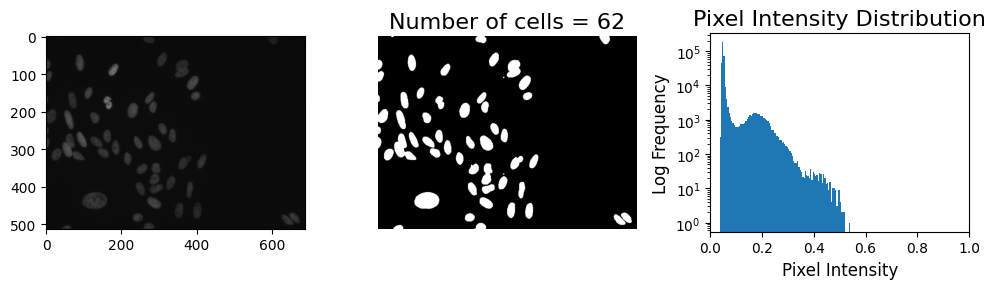

In [6]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(10, 3))

axs[0].imshow(image.permute(1, 2, 0), vmin=0, vmax=1, cmap="gray")

axs[1].imshow(mask.permute(1, 2, 0), vmin=0, vmax=1, cmap="gray")
axs[1].set_title(f"Number of cells = {number_of_cells}", fontsize=16)
axs[1].axis("off")

axs[2].hist(np.array(image).flatten(), bins=200, range=(0, 1))
axs[2].set_xlabel("Pixel Intensity", fontsize=12)
axs[2].set_xlim([0, 1])
axs[2].set_ylabel("Log Frequency", fontsize=12)
axs[2].set_yscale("log")
axs[2].set_title("Pixel Intensity Distribution", fontsize=16)

plt.tight_layout()
plt.show()

## Simulating the Cell Images and Segmentation Masks

### Simulating Images of Cell Nuclei

Simulate a single cell nucleus as an ellipse ...

In [7]:
train_image_size = 256

def random_ellipse_axes():
    """Return the three axes of an ellipse."""
    ellipse_area = (np.random.uniform(3, 4)) ** 2
    radius_ratio = np.random.uniform(1, 1.5)
    major_axis = np.sqrt(ellipse_area) * radius_ratio
    minor_axis = np.sqrt(ellipse_area) / radius_ratio
    z_axis = np.sqrt(ellipse_area) * np.random.uniform(0.2, 0.4)
    return (major_axis, minor_axis, z_axis) * dt.units.um

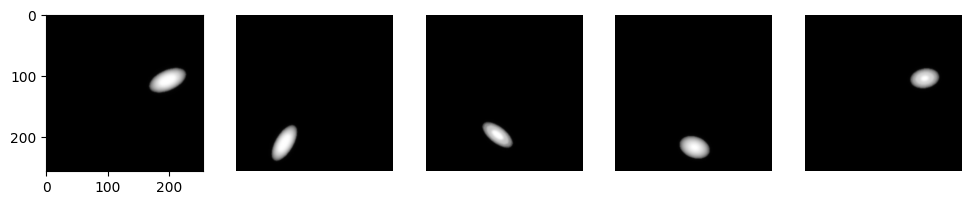

In [8]:
ellipse = dt.Ellipsoid(
    radius = random_ellipse_axes,
    intensity=lambda: np.random.uniform(0.5, 1.5),
    position=lambda: np.random.uniform(5, train_image_size - 5, size=2),
    rotation=lambda: np.random.uniform(0, 2 * np.pi),
)
optics = dt.Fluorescence(
    resolution=1e-6, magnification=6, wavelength=400e-9,
    NA=lambda: np.random.uniform(0.9, 1.1),
    output_region=(0, 0, train_image_size, train_image_size),
)
sim_im_pip = optics(ellipse)

fig, axs = plt.subplots(1, 5, figsize=(10, 2))
for i, ax in enumerate(axs):
    sim_im_pip.update()
    image = sim_im_pip()
    ax.imshow(image, cmap="gray")
    if i != 0: ax.axis("off")
plt.tight_layout()
plt.show()

... simulate multiple nuclei as ellipses with elastic deformations ...

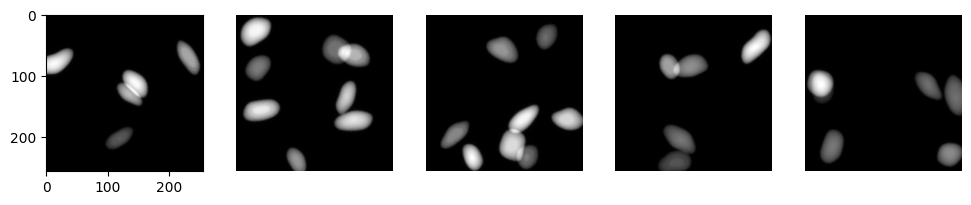

In [9]:
ellipse = dt.Ellipsoid(
    radius = random_ellipse_axes,
    intensity=lambda: np.random.uniform(0.5, 1.5),
    position=lambda: np.random.uniform(5, train_image_size - 5, size=2),
    rotation=lambda: np.random.uniform(0, 2 * np.pi),
)
synthetic_nuclei = (
    (ellipse ^ (lambda: np.random.randint(5, 10)))
    >> dt.Pad(px=(10, 10, 10, 10), keep_size=False)
    >> dt.ElasticTransformation(alpha=100, sigma=10, order=1)
    >> dt.CropTight()
)
optics = dt.Fluorescence(
    resolution=1e-6, magnification=6, wavelength=400e-9,
    NA=lambda: np.random.uniform(0.9, 1.1),
    output_region=(0, 0, train_image_size, train_image_size),
)
sim_im_pip = optics(synthetic_nuclei)

fig, axs = plt.subplots(1, 5, figsize=(10, 2))
for i, ax in enumerate(axs):
    sim_im_pip.update()
    image = sim_im_pip()
    ax.imshow(image, cmap="gray")
    if i != 0: ax.axis("off")
plt.tight_layout()
plt.show()

... simulate multiple nuclei as ellipses with elastic deformations and noise ...

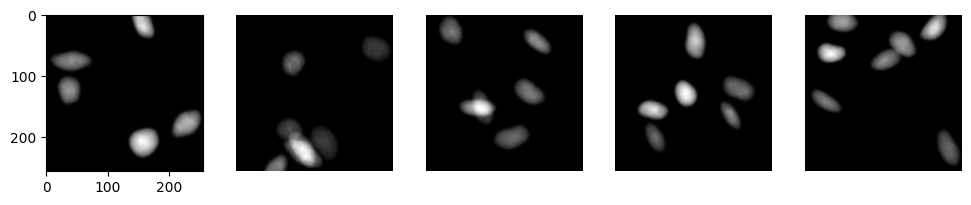

In [10]:
ellipse = dt.Ellipsoid(
    radius = random_ellipse_axes,
    intensity=lambda: np.random.uniform(0.5, 1.5),
    position=lambda: np.random.uniform(5, train_image_size - 5, size=2),
    rotation=lambda: np.random.uniform(0, 2 * np.pi),
)
synthetic_nuclei = (
    (ellipse ^ (lambda: np.random.randint(5, 10)))
    >> dt.Pad(px=(10, 10, 10, 10), keep_size=False)
    >> dt.ElasticTransformation(alpha=100, sigma=10, order=1)
    >> dt.CropTight()
)
synthetic_nuclei_mask = synthetic_nuclei > 0
long_range_noise = (synthetic_nuclei >> dt.Poisson(snr=0.2)
                    >> dt.GaussianBlur(sigma=3.5))
short_range_noise = (synthetic_nuclei >> dt.Poisson(snr=1.0)
                     >> dt.GaussianBlur(sigma=1.5))
random_range_noise = (
    synthetic_nuclei
    >> dt.Poisson(snr=lambda: np.random.uniform(0.5, 1.5))
    >> dt.GaussianBlur(sigma=lambda: np.random.uniform(0.75, 1.5))
)
noisy_synthetic_nuclei = (
    synthetic_nuclei_mask
    * (long_range_noise + short_range_noise + random_range_noise) / 3
)

optics = dt.Fluorescence(
    resolution=1e-6, magnification=6, wavelength=400e-9,
    NA=lambda: np.random.uniform(0.9, 1.1),
    output_region=(0, 0, train_image_size, train_image_size),
)
sim_im_pip = optics(noisy_synthetic_nuclei)

fig, axs = plt.subplots(1, 5, figsize=(10, 2))
for i, ax in enumerate(axs):
    sim_im_pip.update()
    image = sim_im_pip()
    ax.imshow(image, cmap="gray")
    if i != 0: ax.axis("off")
plt.tight_layout()
plt.show()

... simulate multiple nuclei as non-overlapping ellipses with elastic deformations and noise ...

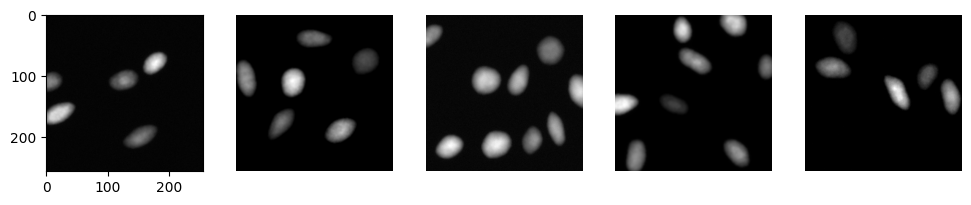

In [11]:
ellipse = dt.Ellipsoid(
    radius = random_ellipse_axes,
    intensity=lambda: np.random.uniform(0.5, 1.5),
    position=lambda: np.random.uniform(5, train_image_size - 5, size=2),
    rotation=lambda: np.random.uniform(0, 2 * np.pi),
)
synthetic_nuclei = (
    (ellipse ^ (lambda: np.random.randint(5, 10)))
    >> dt.Pad(px=(10, 10, 10, 10), keep_size=False)
    >> dt.ElasticTransformation(alpha=100, sigma=10, order=1)
    >> dt.CropTight()
)
synthetic_nuclei_mask = synthetic_nuclei > 0
long_range_noise = (synthetic_nuclei >> dt.Poisson(snr=0.2)
                    >> dt.GaussianBlur(sigma=3.5))
short_range_noise = (synthetic_nuclei >> dt.Poisson(snr=1.0)
                     >> dt.GaussianBlur(sigma=1.5))
random_range_noise = (
    synthetic_nuclei
    >> dt.Poisson(snr=lambda: np.random.uniform(0.5, 1.5))
    >> dt.GaussianBlur(sigma=lambda: np.random.uniform(0.75, 1.5))
)
noisy_synthetic_nuclei = (
    synthetic_nuclei_mask
    * (long_range_noise + short_range_noise + random_range_noise) / 3
)

non_overlap_nuclei = dt.NonOverlapping(noisy_synthetic_nuclei, min_distance=6)

optics = dt.Fluorescence(
    resolution=1e-6, magnification=6, wavelength=400e-9,
    NA=lambda: np.random.uniform(0.9, 1.1),
    output_region=(0, 0, train_image_size, train_image_size),
)
sim_im_pip = (optics(non_overlap_nuclei)
              >> dt.Gaussian(sigma=lambda: np.random.uniform(0, 0.1))
              >> dt.Divide(lambda: np.random.uniform(14, 20))
              >> dt.Add(lambda: np.random.uniform(-0.05, 0.15))
              >> dt.Clip(0, 1) >> dt.AsType("float"))

fig, axs = plt.subplots(1, 5, figsize=(10, 2))
for i, ax in enumerate(axs):
    sim_im_pip.update()
    image = sim_im_pip()
    ax.imshow(image, cmap="gray")
    if i != 0: ax.axis("off")
plt.tight_layout()
plt.show()

### Simulating the Segmentation Masks

Create now the pipeline to simulate the segmentation mask corresponding to the simualte cell image.

In [12]:
def get_mask(radius):
    """Apply isotropic erosion to a binary mask."""
    def inner(mask):
        mask = np.sum(mask, -1, keepdims=True) > 0
        mask = np.pad(mask, [(1, 1), (1, 1), (0, 0)], mode="constant")
        mask = skmorph.isotropic_erosion(mask, radius=radius)
        return mask[1:-1, 1:-1]
    return inner

sim_mask_pip = (
    non_overlap_nuclei
    >> dt.SampleToMasks(get_mask, radius=6, output_region=optics.output_region,
                       merge_method="or")
    >> dt.AsType("float")
)

### Combining the Image and Segmentation Pipelines

In [13]:
sim_im_mask_pip = ((sim_im_pip & sim_mask_pip) >> dt.MoveAxis(2, 0)
                   >> dt.pytorch.ToTensor(dtype=torch.float))
train_dataset = dt.pytorch.Dataset(sim_im_mask_pip, length=640, replace=0.01)

### Visualizing a simulated image and relative segmentation mask

/var/folders/rf/xh_185_x0sl5vv3vjbwyt0r40000gn/T/ipykernel_15768/2940942661.py:12: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  axs[2].hist(np.array(sim_im).flatten(), bins=200, range=(0, 1))


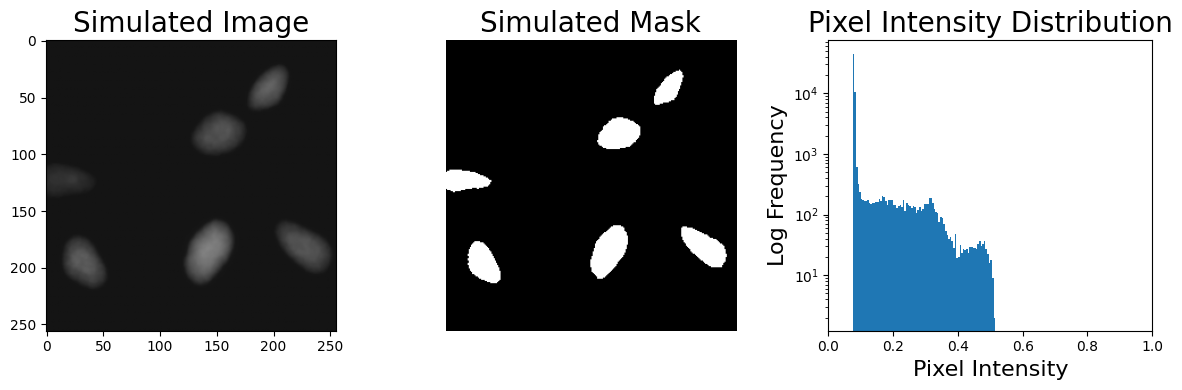

In [14]:
sim_im, sim_mask = train_dataset[np.random.choice(len(train_dataset))]

fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].imshow(sim_im.permute(1, 2, 0), vmin=0, vmax=1, cmap="gray")
axs[0].set_title("Simulated Image", fontsize=20)

axs[1].imshow(sim_mask.permute(1, 2, 0), vmin=0, vmax=1, cmap="gray")
axs[1].set_title("Simulated Mask", fontsize=20)
axs[1].axis("off")

axs[2].hist(np.array(sim_im).flatten(), bins=200, range=(0, 1))
axs[2].set_xlabel("Pixel Intensity", fontsize=16)
axs[2].set_xlim([0, 1])
axs[2].set_ylabel("Log Frequency", fontsize=16)
axs[2].set_yscale("log")
axs[2].set_title("Pixel Intensity Distribution", fontsize=20)

plt.tight_layout()
plt.show()

## Implementing and Training the U-Net

Instantiate the U-Net ...

In [15]:
unet = dl.UNet2d(in_channels=1, channels=[16, 32, 64], out_channels=1)

... compile it ...

In [16]:
unet_reg = dl.Regressor(
    model=unet, loss=torch.nn.BCEWithLogitsLoss(), optimizer=dl.Adam(),
).create()

... and train it.

In [17]:
train_loader = dl.DataLoader(train_dataset, batch_size=8, shuffle=True)
unet_trainer = dl.Trainer(max_epochs=200, accelerator="auto")
unet_trainer.fit(unet_reg, train_loader)

/Users/cmanzo/Documents/GitHub/Environments/deeptrack_old/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
/Users/cmanzo/Documents/GitHub/Environments/deeptrack_old/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name          ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss          │ BCEWithLogitsLoss │      0 │ train │     0 │
│ 1 │ train_metrics │ MetricCollection  │      0 │ train │     0 │
│ 2 │ val_metrics   │ MetricCollection  │      0 │ train │     0 │
│ 3 │ test_metrics  │ MetricCollection  │      0 │ train │     0 │
│ 4 │ model         │ UNet2d            │  128 K │ train │     0 │
│ 5 │ optimizer     │ Adam              │      0 │ train │     0 │
└───┴───────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 128 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 128 K                                                                                                
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 42                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/Users/cmanzo/Documents/GitHub/Environments/deeptrack_old/lib/python3.12/site-packages/lightning/pytorch/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/Users/cmanzo/Documents/GitHub/Environments/deeptrack_old/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.


Epoch 199: 100%|██████████| 80/80 [00:41<00:00,  1.94it/s, v_num=18, train_loss_step=0.00682, train_loss_epoch=0.008]  


## Testing on Experimental Data

Calculate the cell counts using the labeled and predicted segmentation masks ...

In [18]:
images, masks, preds = [], [], []
for image, mask in test_loader:
    images.append(image)
    masks.append(mask)
    pred = unet_reg(image).detach()
    pred = torch.nn.functional.sigmoid(pred).cpu()
    preds.append(pred)
images, masks, preds = \
    torch.cat(images, dim=0), torch.cat(masks, dim=0), torch.cat(preds, dim=0)

true_count = np.array([skmorph.label(l.squeeze()).max() for l in masks])
pred_count = np.array([skmorph.label(p.squeeze() > .995).max() for p in preds])

mae = abs(pred_count - true_count).mean()
mpe = (abs(pred_count[true_count > 0] - true_count[true_count > 0])
       / (true_count[true_count > 0])).mean()

... plot an image of cells with labeled and predicted segmentations ...

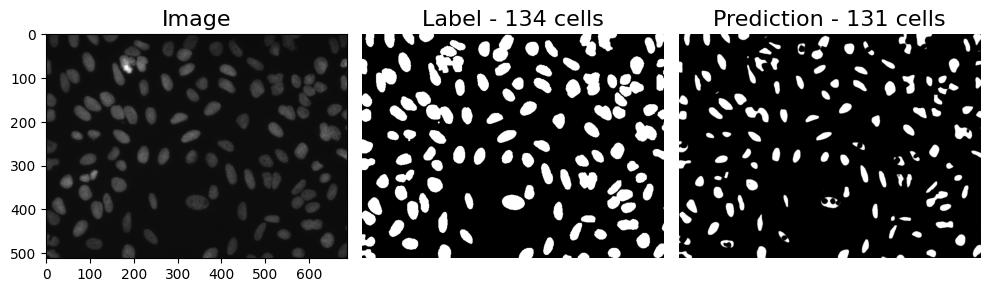

In [19]:
i = np.random.choice(len(images))

fig, axs = plt.subplots(1, 3, figsize=(10, 4))

axs[0].imshow(images[i].squeeze(), vmin=0, vmax=1, cmap="gray")
axs[0].set_title("Image", fontsize=16)

axs[1].imshow(masks[i].squeeze(), vmin=0, vmax=1, cmap="gray")
axs[1].set_title(f"Label - {true_count[i]} cells", fontsize=16)
axs[1].axis("off")

axs[2].imshow(preds[i].squeeze(), cmap="gray")
axs[2].set_title(f"Prediction - {pred_count[i]} cells", fontsize=16)
axs[2].axis("off")

plt.tight_layout()
plt.show()

... and plot the predicted cell counts vs. the true cell counts.

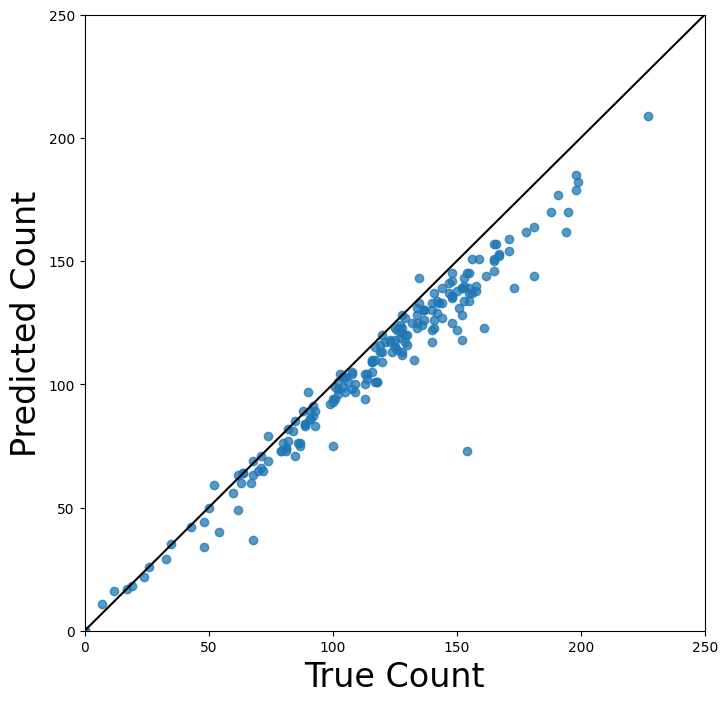

In [20]:
plt.figure(figsize=(8, 8))
plt.scatter(true_count, pred_count, alpha=0.75)
plt.axline([0, 0], [1, 1], color="black")
plt.xlabel("True Count", fontsize=24)
plt.xlim(0, 250)
plt.ylabel("Predicted Count", fontsize=24)
plt.ylim(0, 250)
plt.show()